In [3]:
import copy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from src.utils import load_target_sample

In [4]:
target = load_target_sample()
target.head()

,Season,team_a,team_b,in_target
ID,,,,
2014_1107_1110,2014,1107,1110,True
2014_1107_1112,2014,1107,1112,True
2014_1107_1113,2014,1107,1113,True
2014_1107_1124,2014,1107,1124,True
2014_1107_1140,2014,1107,1140,True


In [5]:
ncaa_games = pd.read_csv('data/NCAATourneyCompactResults.csv')
ncaa_games = ncaa_games.astype({
    'LTeamID': str,
    'WTeamID': str,
    'Season': str
})
ncaa_games['diff'] = ncaa_games['WScore'] - ncaa_games['LScore']
print(ncaa_games.shape)
ncaa_games.sample()

(2117, 9)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,diff
857,1998,138,1449,81,1350,66,N,0,15


In [6]:
regular_games = pd.read_csv('data/RegularSeasonCompactResults.csv')
regular_games = regular_games.astype({
    'LTeamID': str,
    'WTeamID': str,
    'Season': str
})
regular_games['diff'] = regular_games['WScore'] - regular_games['LScore']
print(regular_games.shape)
regular_games.sample()

(150684, 9)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,diff
131978,2014,75,1181,95,1301,60,H,0,35


In [59]:
from sklearn.preprocessing import LabelEncoder


coaches = pd.read_csv('data/TeamCoaches.csv').astype({
    'Season': str,
    'TeamID': str
})
le = LabelEncoder()
coaches['coach'] = le.fit_transform(coaches['CoachName'])
coaches.drop(['CoachName', 'LastDayNum', 'FirstDayNum'], axis=1, inplace=True)
coaches.drop_duplicates(['Season', 'TeamID'], inplace=True)
coaches.sample()

,Season,TeamID,coach
1377,1989,1373,916


In [78]:
data = cp.deepcopy(ncaa_games)
# data = pd.concat([ncaa_games, regular_games])
data['team_a'] = data[['WTeamID', 'LTeamID']].apply(lambda t: t[0] if int(t[0]) < int(t[1]) else t[1], axis=1)
data['team_b'] = data[['WTeamID', 'LTeamID']].apply(lambda t: t[0] if int(t[0]) > int(t[1]) else t[1], axis=1)
data['a_win'] = data['WTeamID'] == data['team_a']
data = data[['Season', 'team_a', 'team_b', 'a_win', 'DayNum']]
data = pd.concat([data, target.reset_index(drop=True)], ignore_index=True)\
    .fillna(0).astype({'a_win': bool, 'in_target': bool})

data = pd.merge(data, coaches, left_on=['Season', 'team_a'],
                right_on=['Season', 'TeamID'], how='left').drop('TeamID', axis=1)
data = pd.merge(data, coaches, left_on=['Season', 'team_b'],
                right_on=['Season', 'TeamID'], how='left', suffixes=['_a', '_b']).drop('TeamID', axis=1)
    
libfm_feature_cols = ['team_a', 'team_b', 'coach_a', 'coach_b']
                      
data = data.dropna()
data.head(5)

,DayNum,Season,a_win,in_target,team_a,team_b,coach_a,coach_b
0,136.0,1985,True,False,1116,1234,394,455
1,136.0,1985,True,False,1120,1345,1204,445
2,136.0,1985,True,False,1207,1250,712,1309
3,136.0,1985,True,False,1229,1425,98,1209
4,136.0,1985,True,False,1242,1325,783,263


In [100]:
from sklearn.datasets import dump_svmlight_file
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder


X = data[~data.in_target.astype(bool)][libfm_feature_cols]
y = data[~data.in_target.astype(bool)][['a_win']].values.reshape(-1)

n_splits = 3
path = 'data/libfm/cv_{}-{:d}-of-X-shuffle.{}'.replace('X', str(n_splits))
kf = KFold(n_splits=3, shuffle=True)
metrics = []
for i, (train_index, test_index) in enumerate(kf.split(X)):
    with open(path.format("train", i, "libfm"),'wb') as f:
        dump_svmlight_file(OneHotEncoder().fit_transform(X.iloc[train_index]),
                           y[train_index], f)
        
    with open(path.format("test", i, "libfm"),'wb') as f:
        dump_svmlight_file(OneHotEncoder().fit_transform(X.iloc[test_index]),
                           0.5*np.ones(X.iloc[test_index].shape[0]), f)
        
    !dist/libfm/bin/LibFM\
        -task c\
        -test data/libfm/cv_test-{i}-of-{n_splits}-shuffle.libfm\
        -train data/libfm/cv_train-{i}-of-{n_splits}-shuffle.libfm \
        -verbosity 0\
        -out data/libfm/predictions.csv\
        -dim '1,1,8'\
        -iter 10\
        -init_stdev .1
        
    preds = np.loadtxt('data/libfm/predictions.csv')
    metric = log_loss(y[test_index], preds)
    metrics.append(metric)
    
!ls data/libfm/
print('Metric Mean: {:.2f} ({:.2f})'.format(np.mean(metrics), np.std(metrics)))

----------------------------------------------------------------------------
libFM
  Version: 1.4.4
  Author:  Steffen Rendle, srendle@libfm.org
  WWW:     http://www.libfm.org/
This program comes with ABSOLUTELY NO WARRANTY; for details see license.txt.
This is free software, and you are welcome to redistribute it under certain
conditions; for details see license.txt.
----------------------------------------------------------------------------
Loading train...	
has x = 0
has xt = 1
num_rows=1411	num_values=5644	num_features=1127	min_target=0	max_target=1
Loading test... 	
has x = 0
has xt = 1
num_rows=706	num_values=2824	num_features=855	min_target=0.5	max_target=0.5
#relations: 0
Loading meta data...	
#Iter=  0	Train=0.641389	Test=0.42068	Test(ll)=0.322751
#Iter=  1	Train=0.617293	Test=0.345609	Test(ll)=0.32667
#Iter=  2	Train=0.635011	Test=0.298867	Test(ll)=0.329065
#Iter=  3	Train=0.625797	Test=0.305949	Test(ll)=0.32589
#Iter=  4	Train=0.627923	Test=0.298867	Test(ll)=0.321791
#Iter

In [102]:
X_enc = OneHotEncoder().fit_transform(X)
X_sub = data[data.in_target.astype(bool)][libfm_feature_cols]
X_sub_enc = OneHotEncoder().fit_transform(X_sub)
y_sub = data[data.in_target.astype(bool)][['Season', 'team_a', 'team_b', 'a_win', 'in_target']]

with open('data/libfm/train.libfm','wb') as f:
    dump_svmlight_file(X_enc, y, f)
    
with open('data/libfm/test.libfm','wb') as f:
    dump_svmlight_file(X_sub_enc, y_sub['a_win'].values, f)

!dist/libfm/bin/LibFM\
    -task c\
    -test data/libfm/test.libfm\
    -train data/libfm/train.libfm \
    -verbosity 0\
    -out data/libfm/predictions.csv\
    -iter 10\
    -dim '1,1,8'\
    -init_stdev .1

preds = np.loadtxt('data/libfm/predictions.csv')

sub = cp.deepcopy(y_sub)
sub['Pred'] = preds
sub['ID'] = sub['Season'].map(str) + '_' + sub['team_a'].map(str) + '_' + sub['team_b'].map(str)
sub.set_index('ID', inplace=True)
sub.drop(['Season', 'team_a', 'team_b', 'a_win', 'in_target'], axis=1, inplace=True)
sub.head()

----------------------------------------------------------------------------
libFM
  Version: 1.4.4
  Author:  Steffen Rendle, srendle@libfm.org
  WWW:     http://www.libfm.org/
This program comes with ABSOLUTELY NO WARRANTY; for details see license.txt.
This is free software, and you are welcome to redistribute it under certain
conditions; for details see license.txt.
----------------------------------------------------------------------------
Loading train...	
has x = 0
has xt = 1
num_rows=2117	num_values=8468	num_features=1294	min_target=0	max_target=1
Loading test... 	
has x = 0
has xt = 1
num_rows=9112	num_values=36448	num_features=600	min_target=0	max_target=0
#relations: 0
Loading meta data...	
#Iter=  0	Train=0.66462	Test=0.447322	Test(ll)=0.318548
#Iter=  1	Train=0.657062	Test=0.44392	Test(ll)=0.314869
#Iter=  2	Train=0.653755	Test=0.489574	Test(ll)=0.305561
#Iter=  3	Train=0.630609	Test=0.493196	Test(ll)=0.30451
#Iter=  4	Train=0.639584	Test=0.497476	Test(ll)=0.304101
#Iter= 

,Pred
ID,
2014_1107_1110,0.447601
2014_1107_1112,0.566460
2014_1107_1113,0.453096
2014_1107_1124,0.468512
2014_1107_1140,0.465273


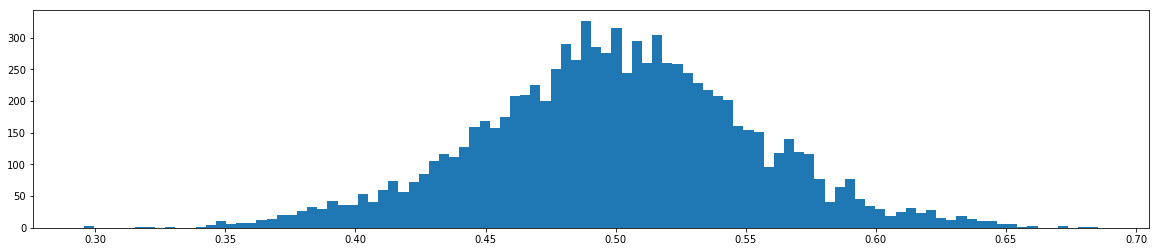

In [103]:
plt.figure(figsize=(20,4))
plt.hist(sub['Pred'], bins=100)
plt.show()

In [113]:
model_out.sample()

,Season,team_a,team_b,a_win,in_target,DayNum
11142,2017,1423,1437,False,True,0.0


In [115]:
test_index[-10:]

array([2076, 2080, 2083, 2096, 2097, 2106, 2107, 2108, 2109, 2114])

In [124]:
np.concatenate(all_preds).shape

(2117,)

In [128]:
all_preds = []
        
for i, (train_index, test_index) in enumerate(kf.split(data)):
    
    with open(path.format("train", i, "libfm"),'wb') as f:
        dump_svmlight_file(OneHotEncoder().fit_transform(data[libfm_feature_cols].iloc[train_index]),
                           data.a_win.iloc[train_index].values, f)
        
    with open(path.format("test", i, "libfm"),'wb') as f:
        dump_svmlight_file(OneHotEncoder().fit_transform(data[libfm_feature_cols].iloc[test_index]),
                           0.5*np.ones(len(test_index)), f)
        
    !dist/libfm/bin/LibFM\
        -task c\
        -test data/libfm/cv_test-{i}-of-{n_splits}-shuffle.libfm\
        -train data/libfm/cv_train-{i}-of-{n_splits}-shuffle.libfm \
        -verbosity 0\
        -out data/libfm/predictions.csv\
        -dim '1,1,8'\
        -iter 10\
        -init_stdev .1
        
    preds = np.loadtxt('data/libfm/predictions.csv')
    all_preds.append(preds)
    
model_out = cp.deepcopy(data[y_sub.columns.tolist() + ['DayNum']])
model_out['Pred'] = np.concatenate(all_preds)
model_out['ID'] = model_out['Season'].map(str) + '_' + model_out['team_a'].map(str) + '_' + model_out['team_b'].map(str)
model_out.set_index('ID', inplace=True)
model_out.head()

----------------------------------------------------------------------------
libFM
  Version: 1.4.4
  Author:  Steffen Rendle, srendle@libfm.org
  WWW:     http://www.libfm.org/
This program comes with ABSOLUTELY NO WARRANTY; for details see license.txt.
This is free software, and you are welcome to redistribute it under certain
conditions; for details see license.txt.
----------------------------------------------------------------------------
Loading train...	
has x = 0
has xt = 1
num_rows=7486	num_values=29944	num_features=1265	min_target=0	max_target=1
Loading test... 	
has x = 0
has xt = 1
num_rows=3743	num_values=14972	num_features=1064	min_target=0.5	max_target=0.5
#relations: 0
Loading meta data...	
#Iter=  0	Train=0.902618	Test=0	Test(ll)=0.675449
#Iter=  1	Train=0.902084	Test=0	Test(ll)=0.714258
#Iter=  2	Train=0.90195	Test=0	Test(ll)=0.74237
#Iter=  3	Train=0.902084	Test=0	Test(ll)=0.768142
#Iter=  4	Train=0.902217	Test=0	Test(ll)=0.786186
#Iter=  5	Train=0.902618	Test=0	Tes

,Season,team_a,team_b,a_win,in_target,DayNum,Pred
ID,,,,,,,
1985_1116_1234,1985,1116,1234,True,False,136.0,0.177474
1985_1120_1345,1985,1120,1345,True,False,136.0,0.123317
1985_1207_1250,1985,1207,1250,True,False,136.0,0.160794
1985_1229_1425,1985,1229,1425,True,False,136.0,0.204822
1985_1242_1325,1985,1242,1325,True,False,136.0,0.125089


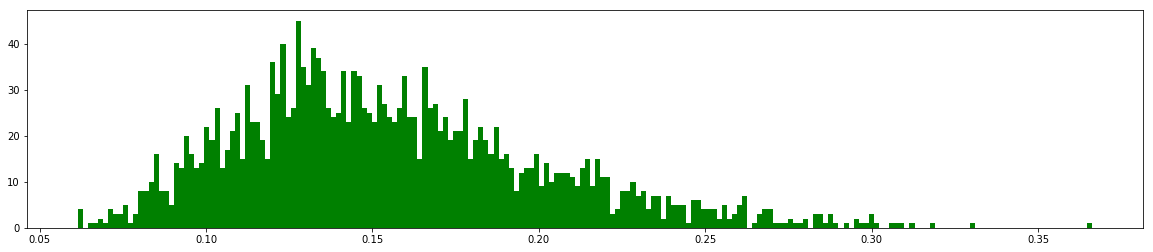

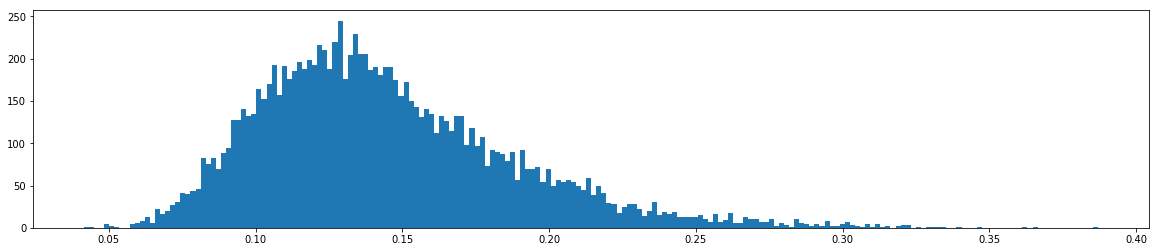

In [129]:
plt.figure(figsize=(20,4))
plt.hist(model_out[~model_out.in_target].Pred, bins=200, color='g')
plt.show()
plt.figure(figsize=(20,4))
plt.hist(model_out.Pred.iloc[-11229:], bins=200)
plt.show()

In [130]:
model_out.to_csv('data/libfm/model_out.csv')